**This file is used to create the training set by Gaussian resampling. Furthermore, some simple tests were performed on the data set.**

In [1]:
import os
import numpy as np
import numba as na
import time

In [2]:
loop_fn = na.prange
#loop_fn = xrange

In [3]:
data = np.load('/data/dell5/userdir/jyj/LAMOST/bstars_info.npy')
print data.shape, (data['label']==1).sum()

(65808,) 3578


Select spectra by SNR and flux:
- averaged SNR > 30
- averaged 100<flux<15000

In [4]:
bool1 = data['snr'].mean(axis=1) > 30
bool2 = (100<data['flux'].mean(axis=1)) * (data['flux'].mean(axis=1)<15000)
data = data[bool1*bool2]
print data.shape, (data['label']==1).sum()

(62426,) 3390


In [5]:
@na.jit(nopython=True)
def GaussKernel(x, mu=0., sigma=0.):
# dwl = 1.38, so sigma should greater than 1.38 at least
    return 1./np.sqrt(2*np.pi*sigma**2.)*np.exp((x-mu)**2./(2*sigma**2.))
    
@na.jit(nopython=True, parallel=True)
def GaussSampling(x, flux, wl, sigma, Iv=None):
    '''
    Iv: inverse variance weight
    wl: wave length
    x: wanted wave length
    '''
    #if x[0] < 3700.+3.*sigma or x[-1] > 9100.-3.*sigma:
    #    print 'selected wavelength should from %d to %d...' %(3700.+3.*sigma,9100.-3.*sigma)
    #    exit()

    flux_new = np.empty((x.shape[0]),dtype=np.float32)
    flux_new[:] = 0.
    for i in loop_fn(len(x)):
        bool = (wl<(x[i]+3*sigma))*(wl>(x[i]-3*sigma))
        flux_i = flux[bool]
        wl_i = wl[bool]
        w = GaussKernel(wl_i,x[i],sigma)
        if Iv is not None:
            Iv_i = Iv[bool]
            value = np.sum(flux_i*w * Iv_i)/np.sum(w*Iv_i)
        else:
            value = np.sum(flux_i*w)/np.sum(w)
        flux_new[i] = value
    return flux_new

def run_GS(data, sigma=3., Iv=None):
    flux = data['flux'].astype(np.float64)
    wl = data['wavelen'].astype(np.float64)
    snr_mask = data['snr_mask_2']
    wl_new = np.linspace(4000.,8800.,4000)
    flux_new = np.zeros([flux.shape[0],wl_new.shape[0]],dtype=np.float64)
    Iv = Iv*(1.-snr_mask)
    if Iv is not None:
        for i in xrange(flux.shape[0]):
    #    for i in xrange(3):
            flux_new[i] = GaussSampling(wl_new, flux[i], wl[i], sigma, Iv=Iv[i])
    else:
        for i in xrange(flux.shape[0]):
            flux_new[i] = GaussSampling(wl_new, flux[i], wl[i], sigma, Iv=None)
    return flux_new.astype(np.float32)
    


# resampling

get inverse variance, and set zero for the data points whose flux is 0

In [6]:
flux = data['flux']
wl = data['wavelen']
snr_mask = data['snr_mask_2']
# get inverse variance  
bool_wl = wl==0
bool_fl = flux==0
bool_all = bool_wl + bool_fl
Iv = data['snr']/flux
Iv = Iv**2.
Iv[bool_all]=0.

/home/maotx/local/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  
/home/maotx/local/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


In [7]:
start = time.time()
flnew = run_GS(data, sigma=3., Iv=Iv)
end = time.time()
print "Elapsed = %s" % (end - start)

Elapsed = 852.694607019


In [8]:
print flnew.dtype
print flnew.shape
print flnew[:10]

float32
(62426, 4000)
[[ 676.20984  686.1009   696.4748  ... 1092.9575  1145.2988  1118.3804 ]
 [ 205.85031  235.80339  247.21407 ...  297.21252  303.10092  286.2816 ]
 [ 387.64288  409.35837  410.39627 ...  454.6292   476.92197  457.87656]
 ...
 [1681.6571  1656.8429  1715.0435  ...  799.54614  815.689    771.7062 ]
 [ 403.12048  415.01138  463.38678 ...  990.9399  1045.8002  1000.7337 ]
 [ 560.71216  530.4638   581.99426 ... 1072.6919  1125.651   1064.5552 ]]


In [9]:
fl = flnew.copy()
bool = (np.isnan(fl).sum(axis=1)==0)
print bool.sum(), bool.shape
fl = fl[bool]
data_new = data[bool].copy()
data_new['flux'] = fl

61502 (62426,)


In [10]:
np.save('/data/dell5/userdir/maotx/DSC/data/resample.npy',data_new)

## check new flux

In [11]:
import matplotlib.pyplot as plt
data_test = np.load('/data/dell5/userdir/maotx/DSC/data/resample.npy')

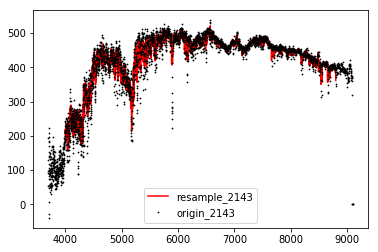

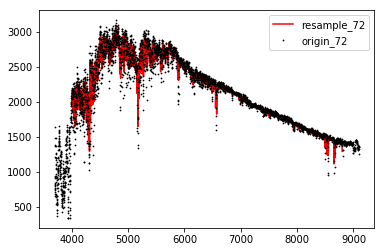

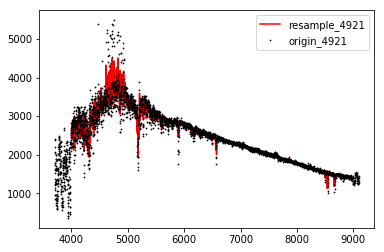

In [12]:
wl_new = np.linspace(4000.,8800.,4000)
for num in [2143,72,4921]:
    ss = data[bool][num]
    wl_s, flux_s = ss['wavelen'], ss['flux']
    plt.plot(wl_new, data_test[num]['flux'], 'r-', label='resample_%d'%num)
    plt.plot(wl_s[wl_s>0], flux_s[wl_s>0], 'k.', ms=1.5, label='origin_%d'%num)
    plt.legend()
    plt.show()

# Create training, validation and test set, TFrecords format.

Seperate dataset for training, validation and test with fraction 0.8,0.1,0.1

In [13]:
data_new = np.load('/data/dell5/userdir/maotx/DSC/data/resample.npy')

In [14]:
frac = np.array([0.8,0.9,1.0])
size = data_new.shape[0]
print size

61502


In [15]:
random_ind = np.random.permutation(np.arange(size))
ind_dataset = np.ceil(frac*size).astype(np.int32)
train_dataset = data_new[random_ind[:ind_dataset[0]]]
valid_dataset = data_new[random_ind[ind_dataset[0]:ind_dataset[1]]]
test_dataset = data_new[random_ind[ind_dataset[1]:ind_dataset[2]]]

In [16]:
print size == np.unique(random_ind).shape[0]
print train_dataset.shape[0]/float(size)
print valid_dataset.shape[0]/float(size)
print test_dataset.shape[0]/float(size)
print train_dataset['label'][:40]
print valid_dataset['label'][:40]
print test_dataset['label'][:40]

True
0.800006503854
0.0999967480732
0.0999967480732
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


### oversampling for training and validation sets:

In [17]:
def oversampling(sample):
    index = np.arange(sample.shape[0])
    dstar_ind = index[sample['label']==1]
    sstar_ind = index[sample['label']==0]
    resample_ind = dstar_ind[np.random.randint(0, dstar_ind.shape[0]-1, sstar_ind.shape[0])]
    ind_new = np.hstack([sstar_ind,resample_ind])
    ind_new = ind_new[np.random.permutation(np.arange(ind_new.shape[0]))]
    return ind_new

In [18]:
reind = oversampling(train_dataset)
train_dataset = train_dataset[reind]
reind = oversampling(valid_dataset)
valid_dataset = valid_dataset[reind]

In [19]:
np.save('/data/dell5/userdir/maotx/DSC/data/training.npy', train_dataset)
np.save('/data/dell5/userdir/maotx/DSC/data/test.npy', test_dataset)
np.save('/data/dell5/userdir/maotx/DSC/data/valid.npy', valid_dataset)

---
## create TFrecord file:

In [20]:
import os
import numpy as np
import tensorflow as tf

Define corresponding data type.

In [21]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

Rewrite the following functions for different dataset.

In [22]:
def convert_to(data_set, Dir, name):
    """Converts a dataset to tfrecords."""
    features = data_set.features
    labels = data_set.labels
    num_examples = data_set.num_examples

    if features.shape[0] != num_examples:
        raise ValueError('Features size %d does not match label size %d.' %
                         (features.shape[0], num_examples))

    filename = os.path.join(Dir, name + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in xrange(num_examples):
        data_set.index = index
        feature_raw = features[index].reshape(-1).tolist()
        label_raw = labels[index].reshape(-1).tolist()
        example = tf.train.Example(features=tf.train.Features(feature={
            'index': _int64_feature(data_set.index),
            'label_raw': _float_feature(label_raw),
            'feature_raw': _float_feature(feature_raw)}))
        writer.write(example.SerializeToString())
    writer.close()

In [23]:
def main(data, filename):
    # Get the data.
    class data_set():
        pass
    Len = data.shape[0]
    features = data['flux']
    labels = data['label'].reshape(-1,1)
  
    data_set.features = features
    data_set.labels = labels
    data_set.num_examples = Len

    convert_to(data_set, Dir='/data/dell5/userdir/maotx/DSC/data', name=filename)

Run the convert code.

In [24]:
main(train_dataset,'training')
main(valid_dataset,'valid')
main(test_dataset,'test')

('Writing', '/data/dell5/userdir/maotx/DSC/data/training.tfrecords')
('Writing', '/data/dell5/userdir/maotx/DSC/data/valid.tfrecords')
('Writing', '/data/dell5/userdir/maotx/DSC/data/test.tfrecords')
